In [1]:

import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio

# visualization settings
plt.style.use('seaborn')
plt.rcParams['figure.facecolor'] = 'white'
pio.renderers.default = 'colab'

# prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet import Prophet

# evaluation metric
from sklearn.metrics import mean_squared_log_error

# others
import itertools
from tqdm import tqdm
import sys

<ipython-input-1-dfdc83a79c9e>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/ODD SEM'
    DATA_DIR = DIR+'/Data/'
else:
    DATA_DIR = 'Data/'

Mounted at /content/drive


In [3]:
#Loading the data
FILE=DATA_DIR+'Sales_.csv'
sales=pd.read_csv(FILE,header=0)
sales.head(5) #displays first 5 rows

,sale_date,product_unit_sales,discount_amount (Rs.),mrp_amount (Rs.),product
0,30-07-2016,1469,841262.54,2772121.0,shirt
1,24-12-2016,2668,951832.49,5265812.0,shirt
2,05-09-2016,595,20077.38,1112225.0,shirt
3,08-09-2016,655,127786.36,1238535.0,shirt
4,17-07-2016,2561,1385088.70,4822249.0,shirt


In [4]:
sales.info() #gives the structure and contents of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sale_date              3112 non-null   object 
 1   product_unit_sales     3112 non-null   int64  
 2   discount_amount (Rs.)  3112 non-null   float64
 3   mrp_amount (Rs.)       3112 non-null   float64
 4   product                3112 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 121.7+ KB


In [5]:
sales['sale_date'] = pd.to_datetime(sales['sale_date'], dayfirst=True) #Converting sale_date column data type from object to datetime64
sales.sort_values('sale_date', inplace=True) #Sort the data ascending by date column
sales['total_revenue'] = (sales['mrp_amount (Rs.)'] - sales['discount_amount (Rs.)'])*sales['product_unit_sales'] #computing the total revenue generated from each sale after applying any discounts
sales.dtypes

None


,0
sale_date,datetime64[ns]
product_unit_sales,int64
discount_amount (Rs.),float64
mrp_amount (Rs.),float64
product,object
total_revenue,float64


In [ ]:
date = pd.Series(['30-01-2021', '31-01-2021', '01-02-2021', '02-02-2021']) #creating a series of date string inn DD-MM-YYYY format
pd.to_datetime(date)  # format of datetime64 is yyyy-mm-dd

<ipython-input-6-c8c53d717624>:2: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



,0
0,2021-01-30
1,2021-01-31
2,2021-02-01
3,2021-02-02


In [7]:
min,max = (sales['sale_date'].apply(['min', 'max'])) #find the  earliest and latest date range of sales_date data.
print(min,max)

2016-01-01 00:00:00 2024-08-19 00:00:00


In [9]:
#total unit sales of the product for all the 8 years in the data
yearly_sales = sales.groupby(sales['sale_date'].dt.year)['product_unit_sales'].sum()
yearly_sales

,product_unit_sales
sale_date,
2016,336955
2017,310557
2018,319559
2019,277193
2020,147819
2021,188996
2022,250505
2023,230842
2024,125472


In [10]:
#Find top 3 years with highest sales
top_3_years = sales['sale_date'].dt.year.value_counts().head(3)
top_3_years
sales_top_years_data = sales[ sales['sale_date'].dt.year.isin(yearly_sales.index)]
sales_top_years_data.head(3)

,sale_date,product_unit_sales,discount_amount (Rs.),mrp_amount (Rs.),product,total_revenue
225,2016-01-01,831,209547.22,1476259.0,shirt,1.052637e+09
164,2016-01-02,1209,398611.22,2140831.0,shirt,2.106344e+09
209,2016-01-03,1637,556444.28,2943443.0,shirt,3.907517e+09


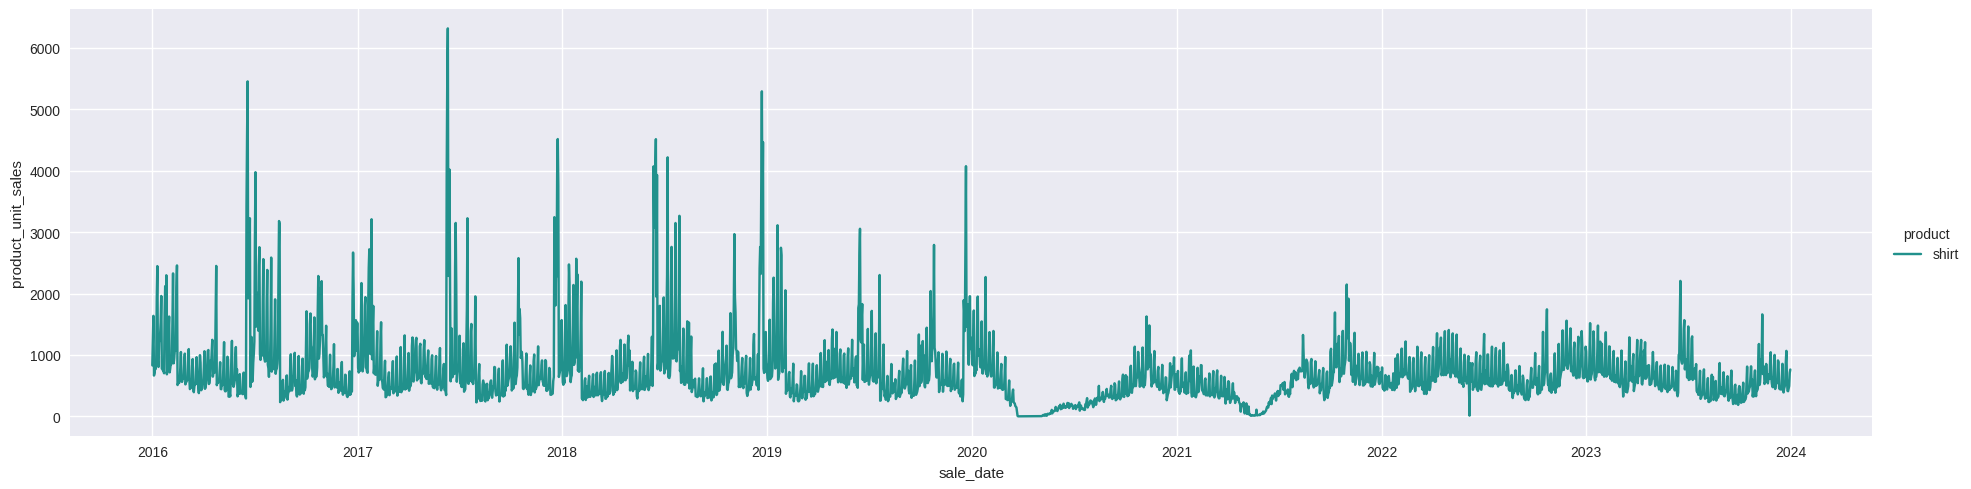

In [ ]:
#Plot of sales in all the years

import matplotlib.pyplot as plt
top_8_years = sales['sale_date'].dt.year.value_counts().head(8)
sales_top_years_data = sales[sales['sale_date'].dt.year.isin(top_8_years.index)]
sns.relplot(data=sales_top_years_data,
            kind='line',
            x='sale_date',
            y='product_unit_sales',
            palette="viridis",
            hue = "product",
            aspect=19/5)
plt.show()

In [ ]:
# Group by year and sum the product unit sales
yearly_sales = sales.groupby(sales['sale_date'].dt.year)['product_unit_sales'].sum()

# Reset the index to convert Series to DataFrame
yearlysale = yearly_sales.reset_index()

# Rename the columns
yearlysale = yearlysale.rename(columns={'sale_date': 'ds', 'product_unit_sales': 'y'})

# Display the first few rows
yearlysale.head()

,ds,y
0,2016,336955
1,2017,310557
2,2018,319559
3,2019,277193
4,2020,147819


In [ ]:
#Based on the existing data we will forecast for 1 year into the future
sales['sale_date'] = pd.to_datetime(sales['sale_date'], dayfirst=True)

# Rename columns for Prophet
sales = sales.rename(columns={'sale_date': 'ds', 'product_unit_sales': 'y'})
model_31 = Prophet()

# Fit the model with your historical data
model_31.fit(sales)
future_32 = model_31.make_future_dataframe(periods=6, freq='M')
forecast_32 = model_31.predict(future_32)

# Display the predictions for the next 6 months
forecast_next_6_months = forecast_32[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)
print(forecast_next_6_months)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpby1bk7k4/g9zpembc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpby1bk7k4/64j940v4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8091', 'data', 'file=/tmp/tmpby1bk7k4/g9zpembc.json', 'init=/tmp/tmpby1bk7k4/64j940v4.json', 'output', 'file=/tmp/tmpby1bk7k4/prophet_modelw5_b9xh5/prophet_model-20240824071141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:11:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:11:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds        yhat  yhat_lower   yhat_upper
3112 2024-08-31  557.191889    3.526930  1088.519058
3113 2024-09-30  215.185219 -292.073697   780.262759
3114 2024-10-31  507.808288  -34.619400  1093.066228
3115 2024-11-30  557.092699   48.401005  1107.999812
3116 2024-12-31  593.616731   60.271423  1121.938427
3117 2025-01-31  591.615731   39.613681  1097.927085


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



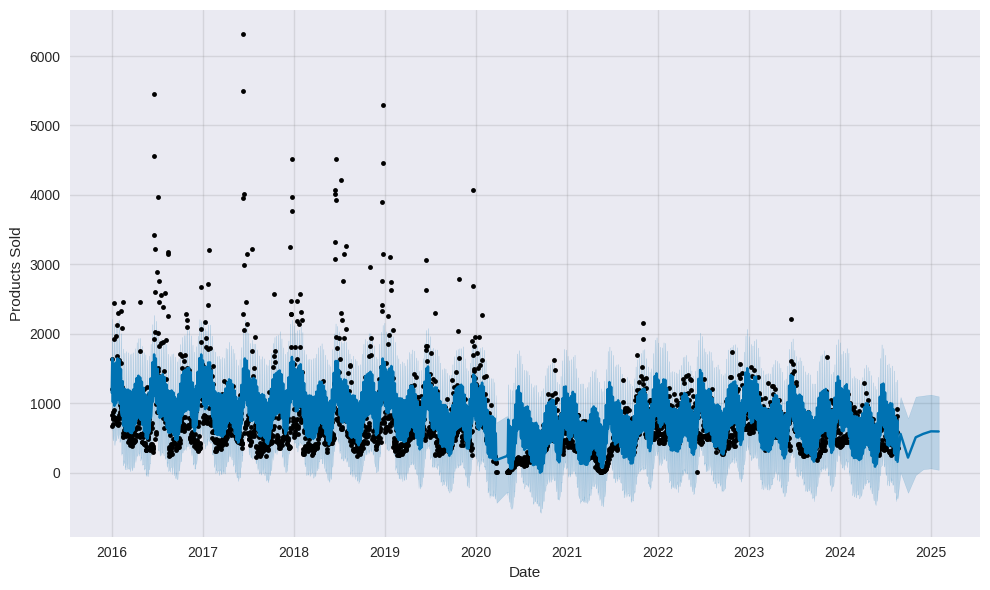

In [ ]:
# shows the forecasting result.
#The black points in the plot shows the actual time series, and the blue line shows the fitted time series along with its forecasted values 365 days into the future.
forecast_result =forecast_32['yhat']
forecast_add_components =forecast_32['trend'] + forecast_32['weekly'] + forecast_32['yearly']

(forecast_result.round(10) == forecast_add_components.round(10)).all()

fig = model_31.plot(forecast_32, xlabel='Date', ylabel='Products Sold')


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



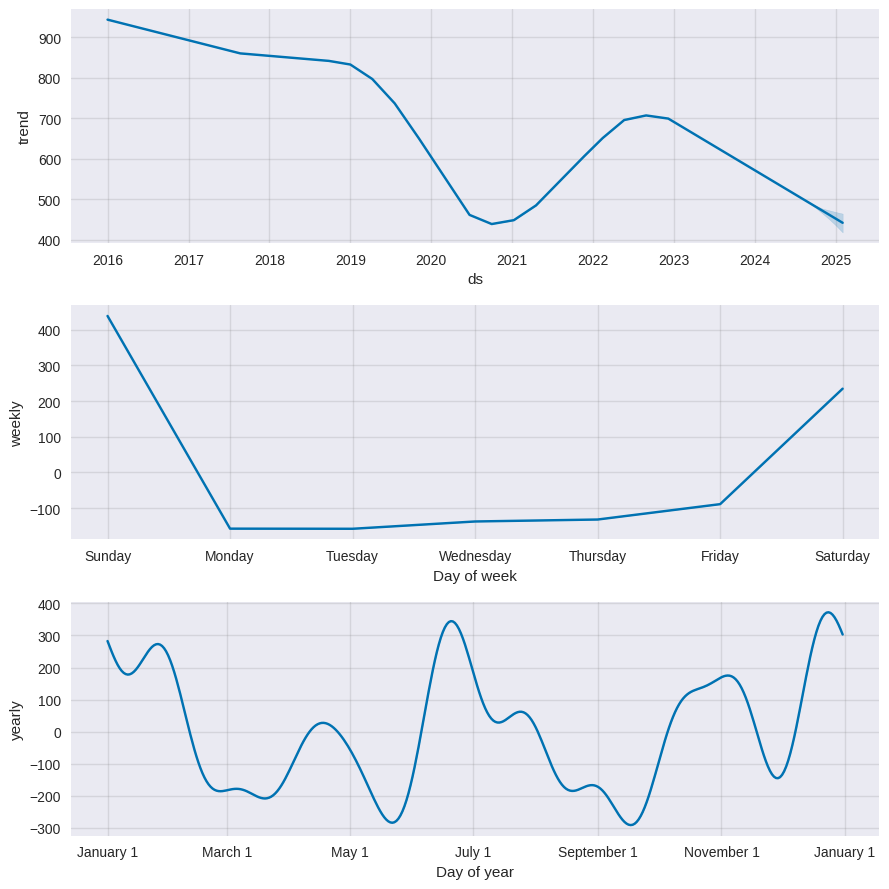

In [ ]:
#visualizing
fig = model_31.plot_components(forecast_32)

In [ ]:
plot_plotly(model_31, forecast_32)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
plot_components_plotly(model_31, forecast_32)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

